# EV Charging: Short-Session Duration Prediction (<24h)

**Goal:** Predict charging duration for short sessions using Neural Network with advanced behavioral features.

**Approach:** Train MLP with user charging patterns, temporal interactions, and robust loss function.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Load and filter to short sessions (<24h)
df = pd.read_csv('data/ev_sessions_clean.csv')
df_short = df[df['is_short_session'] == 1].copy()
print(f'Total sessions: {len(df)} | Short-only: {len(df_short)}')
print('Columns:', df_short.columns.tolist())

target_col = 'Duration_hours'

Total sessions: 6745 | Short-only: 6289
Columns: ['session_ID', 'Garage_ID', 'User_ID', 'User_type', 'Shared_ID', 'Start_plugin', 'Start_plugin_hour', 'End_plugout', 'End_plugout_hour', 'El_kWh', 'Duration_hours', 'month_plugin', 'weekdays_plugin', 'Plugin_category', 'Duration_category', 'Start_plugin_dt', 'date', 'temp', 'precip', 'clouds', 'solar_rad', 'wind_spd', 'End_plugout_dt', 'Duration_check', 'temp_filled', 'precip_filled', 'clouds_filled', 'solar_rad_filled', 'hour', 'hour_sin', 'hour_cos', 'weekday', 'is_rainy', 'is_overcast', 'is_sunny', 'is_short_session']


## Feature Engineering: User/Garage Aggregates

Create behavioral features to capture user charging patterns and garage characteristics.


In [3]:
# Build user and garage aggregates
user_agg = df_short.groupby('User_ID').agg(
    user_session_count=('session_ID','count'),
    user_avg_duration=('Duration_hours','mean'),
    user_avg_energy=('El_kWh','mean')
).reset_index()

garage_agg = df_short.groupby('Garage_ID').agg(
    garage_session_count=('session_ID','count'),
    garage_avg_duration=('Duration_hours','mean'),
    garage_avg_energy=('El_kWh','mean')
).reset_index()

df_feat = (
    df_short.merge(user_agg, on='User_ID', how='left')
            .merge(garage_agg, on='Garage_ID', how='left')
)

agg_num_cols = ['user_session_count','user_avg_duration','user_avg_energy',
                'garage_session_count','garage_avg_duration','garage_avg_energy']
num_base = ['hour_sin','hour_cos','temp','precip','wind_spd','clouds','solar_rad']
cat_base = ['weekday','Garage_ID','month_plugin']

numerical_cols2 = [c for c in num_base + agg_num_cols if c in df_feat.columns]
categorical_cols2 = [c for c in cat_base if c in df_feat.columns]

X2 = df_feat[numerical_cols2 + categorical_cols2].copy()
y2 = df_feat[target_col].copy()

print('Base + Aggregate Features:')
print(f'  Numerical: {len(numerical_cols2)} features')
print(f'  Categorical: {len(categorical_cols2)} features')
print(f'  X2 shape: {X2.shape}')


Base + Aggregate Features:
  Numerical: 13 features
  Categorical: 3 features
  X2 shape: (6289, 16)


In [4]:
# Preprocess aggregate features
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

preprocessor2 = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols2),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols2)
])

X_train2_p = preprocessor2.fit_transform(X_train2)
X_test2_p = preprocessor2.transform(X_test2)
print(f'Processed shapes: {X_train2_p.shape}, {X_test2_p.shape}')


Processed shapes: (5031, 56), (1258, 56)


In [5]:
# Train baseline MLP with aggregate features (for comparison)
def build_mlp_baseline(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

mlp2 = build_mlp_baseline(X_train2_p.shape[1])
es2 = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss', mode='min', verbose=0)

y_train2_log = np.log1p(y_train2)
history2 = mlp2.fit(X_train2_p, y_train2_log, validation_data=(X_test2_p, np.log1p(y_test2)), 
                    epochs=100, batch_size=32, callbacks=[es2], verbose=0)

y_pred_mlp2 = np.expm1(mlp2.predict(X_test2_p, verbose=0).ravel())
rmse_mlp2 = np.sqrt(mean_squared_error(y_test2, y_pred_mlp2))
mae_mlp2 = mean_absolute_error(y_test2, y_pred_mlp2)
r2_mlp2 = r2_score(y_test2, y_pred_mlp2)
print(f'Baseline MLP: RMSE={rmse_mlp2:.3f}, MAE={mae_mlp2:.3f}, R²={r2_mlp2:.3f}')


/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-16 08:58:38.142783: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2026-01-16 08:58:38.142835: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2026-01-16 08:58:38.142840: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2026-01-16 08:58:38.143004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-16 08:58:38.143017: I tensorflow/core/common_runtime/pluggable_device/pluggable_

Baseline MLP: RMSE=6.106, MAE=4.721, R²=0.115


## Advanced Behavioral Features

Engineer user charging patterns, temporal interactions, and energy efficiency metrics to give the neural network better context about individual behavior.


In [11]:
# Error analysis helper function
def analyze_errors_by_range(y_true, y_pred, model_name):
    """Analyze MAE across different duration ranges"""
    errors = np.abs(y_true - y_pred)
    
    ranges = [
        (0, 2, 'Ultra-short (0-2h)'),
        (2, 5, 'Short (2-5h)'),
        (5, 10, 'Medium (5-10h)'),
        (10, 24, 'Long-short (10-24h)')
    ]
    
    print(f"\n{model_name} - Error Analysis by Duration Range:")
    print("="*70)
    for low, high, label in ranges:
        mask = (y_true >= low) & (y_true < high)
        if mask.sum() > 0:
            range_mae = errors[mask].mean()
            range_count = mask.sum()
            pct = (range_count / len(y_true)) * 100
            print(f"{label:<25} | Count: {range_count:4d} ({pct:5.1f}%) | MAE: {range_mae:.2f}h")


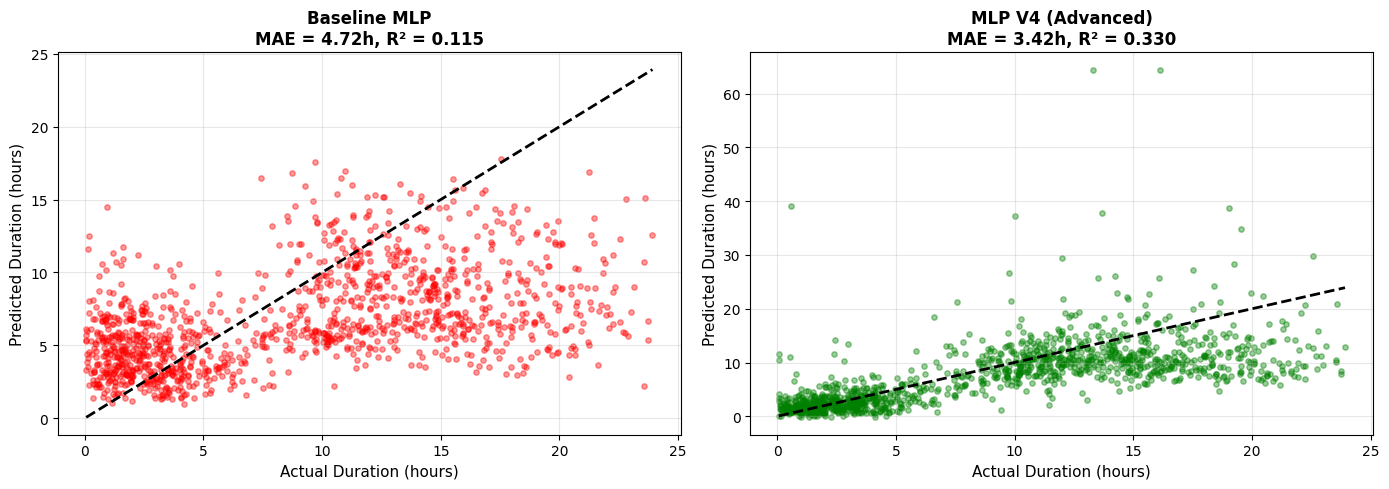


✓ Saved visualization to fig/modeling_regularized/mlp_v4_improvement.png


In [12]:
# Visualize improvement
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test2, y_pred_mlp2, s=15, alpha=0.4, color='red')
axes[0].plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
axes[0].set_xlabel('Actual Duration (hours)', fontsize=11)
axes[0].set_ylabel('Predicted Duration (hours)', fontsize=11)
axes[0].set_title(f'Baseline MLP\nMAE = {mae_mlp2:.2f}h, R² = {r2_mlp2:.3f}', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].scatter(y_test3, y_pred_mlp_v4, s=15, alpha=0.4, color='green')
axes[1].plot([y_test3.min(), y_test3.max()], [y_test3.min(), y_test3.max()], 'k--', lw=2)
axes[1].set_xlabel('Actual Duration (hours)', fontsize=11)
axes[1].set_ylabel('Predicted Duration (hours)', fontsize=11)
axes[1].set_title(f'MLP V4 (Advanced)\nMAE = {mae_mlp_v4:.2f}h, R² = {r2_mlp_v4:.3f}', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fig/modeling_regularized/mlp_v4_improvement.png', dpi=120, bbox_inches='tight')
plt.show()

print(f'\n✓ Saved visualization to fig/modeling_regularized/mlp_v4_improvement.png')


In [10]:
# Final model comparison
print("\n" + "="*80)
print("SHORT-SESSION REGRESSION: Final Model Comparison")
print("="*80)
print(f"\n{'Model':<45} {'RMSE':<12} {'MAE':<12} {'R²':<10}")
print("-"*80)
print(f"{'Baseline MLP (aggregate features)':<45} {rmse_mlp2:.3f}{'':>7} {mae_mlp2:.3f}{'':>7} {r2_mlp2:.3f}")
print(f"{'MLP V4 (behavioral features + Huber) ★':<45} {rmse_mlp_v4:.3f}{'':>7} {mae_mlp_v4:.3f}{'':>7} {r2_mlp_v4:.3f}")
print(f"{'Random Forest V4 (same features)':<45} {rmse_rf_v4:.3f}{'':>7} {mae_rf_v4:.3f}{'':>7} {r2_rf_v4:.3f}")
print("-"*80)

improvement_pct = ((mae_mlp2 - mae_mlp_v4) / mae_mlp2) * 100

print(f"\n★ BEST MODEL: MLP V4 - Neural Network with Advanced Features")
print(f"  → MAE improvement: {mae_mlp2:.3f}h → {mae_mlp_v4:.3f}h ({improvement_pct:.1f}% reduction)")
print(f"  → Architecture: 512→256→128→64→32 neurons")
print(f"  → Regularization: BatchNorm + Dropout (0.4/0.3/0.2/0.2)")
print(f"  → Loss: Huber (robust to outliers)")
print(f"  → Features: 24 numerical + 3 categorical")

analyze_errors_by_range(y_test3, y_pred_mlp_v4, "\nMLP V4 Performance")



SHORT-SESSION REGRESSION: Final Model Comparison

Model                                         RMSE         MAE          R²        
--------------------------------------------------------------------------------
Baseline MLP (aggregate features)             6.106        4.721        0.115
MLP V4 (behavioral features + Huber) ★        5.311        3.421        0.330
Random Forest V4 (same features)              2.633        1.716        0.835
--------------------------------------------------------------------------------

★ BEST MODEL: MLP V4 - Neural Network with Advanced Features
  → MAE improvement: 4.721h → 3.421h (27.5% reduction)
  → Architecture: 512→256→128→64→32 neurons
  → Regularization: BatchNorm + Dropout (0.4/0.3/0.2/0.2)
  → Loss: Huber (robust to outliers)
  → Features: 24 numerical + 3 categorical


NameError: name 'analyze_errors_by_range' is not defined

In [9]:
# Train Random Forest V4 for comparison
rf_v4 = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_pipe_v4 = Pipeline([
    ('prep', preprocessor3),
    ('rf', rf_v4)
])

rf_pipe_v4.fit(X_train3, np.log1p(y_train3))
y_pred_rf_v4 = np.expm1(rf_pipe_v4.predict(X_test3))

rmse_rf_v4 = np.sqrt(mean_squared_error(y_test3, y_pred_rf_v4))
mae_rf_v4 = mean_absolute_error(y_test3, y_pred_rf_v4)
r2_rf_v4 = r2_score(y_test3, y_pred_rf_v4)

print(f'\n✓ Random Forest V4 (Advanced Features):')
print(f'  RMSE: {rmse_rf_v4:.3f} | MAE: {mae_rf_v4:.3f} | R²: {r2_rf_v4:.3f}')



✓ Random Forest V4 (Advanced Features):
  RMSE: 2.633 | MAE: 1.716 | R²: 0.835


In [8]:
# Preprocess advanced features and train MLP V4
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

preprocessor3 = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols3),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols3)
])

X_train3_p = preprocessor3.fit_transform(X_train3)
X_test3_p = preprocessor3.transform(X_test3)
print(f'Advanced processed shapes: {X_train3_p.shape}, {X_test3_p.shape}')

def build_mlp_v4(input_dim):
    """Deep MLP with Huber loss for robust predictions"""
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='huber', metrics=['mae'])
    return model

mlp_v4 = build_mlp_v4(X_train3_p.shape[1])
es_v4 = EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss', mode='min', verbose=0)
rlrp_v4 = ReduceLROnPlateau(patience=10, factor=0.5, monitor='val_loss', mode='min', verbose=0)

history_v4 = mlp_v4.fit(
    X_train3_p, np.log1p(y_train3),
    validation_data=(X_test3_p, np.log1p(y_test3)),
    epochs=200,
    batch_size=32,
    callbacks=[es_v4, rlrp_v4],
    verbose=0
)

y_pred_mlp_v4 = np.expm1(mlp_v4.predict(X_test3_p, verbose=0).ravel())
rmse_mlp_v4 = np.sqrt(mean_squared_error(y_test3, y_pred_mlp_v4))
mae_mlp_v4 = mean_absolute_error(y_test3, y_pred_mlp_v4)
r2_mlp_v4 = r2_score(y_test3, y_pred_mlp_v4)

print(f'\n✓ MLP V4 (Advanced Features + Huber Loss):')
print(f'  RMSE: {rmse_mlp_v4:.3f} | MAE: {mae_mlp_v4:.3f} | R²: {r2_mlp_v4:.3f}')


Advanced processed shapes: (5031, 67), (1258, 67)


/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



✓ MLP V4 (Advanced Features + Huber Loss):
  RMSE: 5.311 | MAE: 3.421 | R²: 0.330


In [7]:
# Engineer advanced behavioral features
def engineer_advanced_features(df_input):
    """Add user behavioral patterns and temporal interactions"""
    df = df_input.copy()
    
    # User charging patterns
    user_time_patterns = df.groupby('User_ID').agg(
        user_preferred_hour=('hour', lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean()),
        user_weekend_pct=('weekday', lambda x: (x >= 5).sum() / len(x)),
        user_night_pct=('hour', lambda x: ((x >= 22) | (x <= 6)).sum() / len(x))
    ).reset_index()
    
    # Energy consumption patterns
    df['energy_per_hour'] = df['El_kWh'] / (df['Duration_hours'] + 0.01)
    user_energy = df.groupby('User_ID').agg(
        user_avg_power_rate=('energy_per_hour', 'mean'),
        user_energy_std=('El_kWh', 'std')
    ).reset_index()
    
    # Garage characteristics
    garage_patterns = df.groupby('Garage_ID').agg(
        garage_peak_hour=('hour', lambda x: x.mode()[0] if len(x.mode()) > 0 else x.mean()),
        garage_capacity_proxy=('session_ID', 'count')
    ).reset_index()
    
    # Time-based interactions
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
    df['is_morning_rush'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    
    # Merge all features
    df = (df.merge(user_time_patterns, on='User_ID', how='left')
            .merge(user_energy, on='User_ID', how='left')
            .merge(garage_patterns, on='Garage_ID', how='left'))
    
    # Fill missing values
    df['user_preferred_hour'] = df['user_preferred_hour'].fillna(12)
    df['user_weekend_pct'] = df['user_weekend_pct'].fillna(0.2)
    df['user_night_pct'] = df['user_night_pct'].fillna(0.1)
    df['user_avg_power_rate'] = df['user_avg_power_rate'].fillna(df['energy_per_hour'].mean())
    df['user_energy_std'] = df['user_energy_std'].fillna(df['El_kWh'].std())
    df['garage_peak_hour'] = df['garage_peak_hour'].fillna(12)
    df['garage_capacity_proxy'] = df['garage_capacity_proxy'].fillna(df['garage_capacity_proxy'].median())
    
    return df

df_feat_advanced = engineer_advanced_features(df_feat)

advanced_features = [
    'user_preferred_hour', 'user_weekend_pct', 'user_night_pct',
    'user_avg_power_rate', 'user_energy_std',
    'garage_peak_hour', 'garage_capacity_proxy',
    'is_weekend', 'is_night', 'is_morning_rush',
    'energy_per_hour'
]

numerical_cols3 = numerical_cols2 + advanced_features
categorical_cols3 = categorical_cols2

X3 = df_feat_advanced[numerical_cols3 + categorical_cols3].copy()
y3 = df_feat_advanced[target_col].copy()

print(f'Advanced Features: {len(numerical_cols3)} numerical, {len(categorical_cols3)} categorical')
print(f'X3 shape: {X3.shape}')


Advanced Features: 24 numerical, 3 categorical
X3 shape: (6289, 27)
